In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Concatenate, GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, Dropout, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



import os
import glob

In [18]:
def normalize_for_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [36]:
width = 64
height = 64

inputs = Input(shape=(width,height,3), name='encoder_input')

x = Conv2D(16, 3, strides=2, padding='same', name='conv_1')(inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.3)(x)

x = Conv2D(32, 3, strides=2, padding='same', name='conv_2')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.3)(x)
                 
x = Conv2D(64, 3, strides=2, padding='same', name='conv_3')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.3)(x)


x = Conv2D(128, 3, strides=2, padding='same', name='conv_4')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.3)(x)

x = Flatten()(x)

x = Dense(128)(x)
x = LeakyReLU(0.1)(x)
x = Dropout(0.3)(x)


x = Dense(40, activation='tanh')(x)

dfc_celeba = Model(inputs, x)

In [27]:
classifier.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_14 (Batc (None, 16, 16, 32)        128 

In [14]:
df = pd.read_csv('./celeba-attribs.csv')

In [34]:
training_split = 0.3

training_data_generator = ImageDataGenerator(
    validation_split=1-training_split,
    horizontal_flip=False,
    preprocessing_function=normalize_for_tanh)

training_generator = training_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='../celeba-clean-64/',
    x_col="img",
    y_col=list(df.columns[1:]),
    target_size=(64, 64),
    subset='training',
    shuffle=True,
    batch_size=int(202599 * traning_split),
    class_mode='raw')

# validation_generator = training_data_generator.flow_from_dataframe(
#     dataframe=df,
#     directory='../celeba-clean-64/',
#     x_col="img",
#     y_col=list(df.columns[1:]),
#     target_size=(64, 64),
#     subset='validation',
#     shuffle=True,
#     batch_size=int(202599 * (1 - traning_split)),
#     class_mode='raw')


Found 60780 validated image filenames.


In [35]:
training_data = training_generator.next()

In [37]:
optimizer = Adam(0.0008)
dfc_celeba.compile(optimizer=optimizer, loss='mean_squared_error')
loss_curve = []

In [39]:
import time
start_epoch = 100
epochs = 101
batch_size = 32

model_type = 'dfc-celeba'

training_imgs = training_data[0]
training_cond = training_data[1]
num_batches = len(training_imgs) // batch_size

for epoch in range(start_epoch,epochs):
    start = time.time()
    print(f'Epoch [{epoch}/{epochs-1}]...'.ljust(20), end = '')

    np.random.seed(epoch)
    np.random.shuffle(training_imgs)
    np.random.seed(epoch)
    np.random.shuffle(training_cond)
    
    loss = 0
    for index in range(num_batches):
        img_input = training_imgs[index*batch_size: batch_size*(index+1)]
        attribute_label = training_cond[index*batch_size: batch_size*(index+1)]
        loss += dfc_celeba.train_on_batch(img_input, attribute_label)
    
    loss /= num_batches
    

    
    print(f'...{time.time()-start:.3f}(s) loss: {loss:.3f}')
    loss_curve.append(loss)
    if epoch % 100 == 0:
        print(f'checkpointing at epoch: {epoch}')
        dfc_celeba.save_weights(f'./checkpoints/epoch-{epoch}-{model_type}-weights.h5')
        dfc_celeba.save(f'./checkpoints/epoch-{epoch}-{model_type}.h5')



Epoch [100/100]...  ...12.272(s) loss: 0.300
checkpointing at epoch: 100


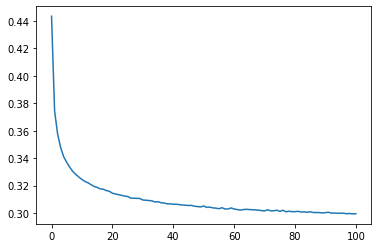

In [40]:
plt.plot(loss_curve)

In [47]:
validation_generator = training_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='../celeba-clean-64/',
    x_col="img",
    y_col=list(df.columns[1:]),
    target_size=(64, 64),
    subset='validation',
    shuffle=True,
    batch_size=3000,
    class_mode='raw')


Found 141819 validated image filenames.


In [48]:
val_data = validation_generator.next()

In [49]:
val_imgs = val_data[0]
val_label = val_data[1]

In [50]:
dfc_celeba.evaluate(val_imgs, val_label)

3000/3000 [==============================] - 0s 132us/sample - loss: 0.2820


0.28200156819820404

In [53]:
pred = dfc_celeba.predict(val_imgs[0].reshape(-1,64,64,3))
tru_label = val_label[0]

In [54]:
print(pred)
print(tru_label)

[[-0.99985224 -0.08938473  0.97040904 -0.70440346 -0.99999917 -0.99965036
  -0.42848286 -0.95455724 -0.9996165   0.93835014 -0.9895698  -0.9256031
  -0.9931181  -0.99929774 -0.9994859  -0.9999709  -0.99987483 -0.9998915
   0.89238536  0.9987409  -0.99998957  0.99789155 -0.9998701  -0.88813955
   0.9999919   0.47865447 -0.9863472  -0.28151008 -0.9967086  -0.8825431
  -0.9999674   0.99999547 -0.11113485 -0.15879342 -0.8694774  -0.9999678
   0.98694485 -0.551671   -0.9999953   0.9885746 ]]
[-1  1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1
  1  1 -1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1 -1  1]
